# EDA Lab + Homework (Student)

**Goal**: practice high-signal EDA like you would in a FAANG ML interview or on-call investigation.

Rules:
- Work top-to-bottom
- Don't hardcode outputs
- Prefer concise, high-signal plots


In [5]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def check(name: str, cond: bool):
    if not cond:
        raise AssertionError(f"Failed: {name}")
    print(f"OK: {name}")

rng = np.random.default_rng(0)

# Offline dataset (embedded CSV). Synthetic but realistic pitfalls: missingness, heavy tails, leakage-like columns.
CSV = """user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
1,US,basic,400,365,2,8.0,25,0.0,0,0,0
2,US,premium,120,110,18,22.0,41,10.0,0,0,0
3,IN,basic,30,25,1,3.0,19,0.0,1,1,1
4,IN,basic,10,7,0,2.0,22,0.0,1,0,0
5,GB,premium,800,790,30,35.0,52,15.0,0,0,0
6,GB,basic,200,180,5,10.0,33,,1,1,1
7,US,basic,60,55,7,12.0,,0.0,0,0,0
8,CA,premium,90,80,14,18.0,29,5.0,0,0,0
9,CA,basic,15,12,0,1.0,24,0.0,1,1,1
10,IN,premium,300,280,20,25.0,38,20.0,0,0,0
11,US,premium,5,3,0,0.5,27,0.0,1,1,1
12,GB,premium,45,40,9,15.0,31,0.0,0,0,0
13,US,basic,500,490,1,6.0,47,0.0,0,0,0
14,IN,basic,75,70,4,9.0,28,0.0,0,0,0
15,CA,basic,365,360,3,7.0,36,0.0,0,0,0
16,US,premium,20,18,0,1.0,23,0.0,1,1,1
17,GB,basic,150,140,6,11.0,42,0.0,0,0,0
18,IN,premium,220,210,25,28.0,34,25.0,0,0,0
19,US,basic,12,10,0,0.2,21,0.0,1,1,1
20,CA,premium,600,590,22,26.0,55,0.0,0,0,0
"""

df = pd.read_csv(io.StringIO(CSV))
check('n_rows', df.shape[0] == 20)
check('has_target', 'churned' in df.columns)
df.head()


OK: n_rows
OK: has_target


,user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
0,1,US,basic,400,365,2,8.0,25.0,0.0,0,0,0
1,2,US,premium,120,110,18,22.0,41.0,10.0,0,0,0
2,3,IN,basic,30,25,1,3.0,19.0,0.0,1,1,1
3,4,IN,basic,10,7,0,2.0,22.0,0.0,1,0,0
4,5,GB,premium,800,790,30,35.0,52.0,15.0,0,0,0


## 1) Sanity Checks — 10 minutes


### Task 1.1: Data grain + schema


In [6]:
# TODO: write 1-2 sentences: what is the grain of this dataset?

# TODO: inspect dtypes; convert to appropriate types if needed
df.dtypes
df['country'] = df['country'].astype('category')
df['plan'] = df['plan'].astype('category')

df['last_payment_failed'] = df['last_payment_failed'].astype(bool)
df['refund_after_churn_flag'] = df['refund_after_churn_flag'].astype(bool)
df.dtypes

# HINT: churned should be int/bool; categorical columns should remain object/category


,0
user_id,int64
country,category
plan,category
signup_days_ago,int64
tenure_days,int64
sessions_last_7d,int64
avg_session_min,float64
age,float64
discount_pct,float64
last_payment_failed,bool


### Task 1.2: Missingness + duplicates


In [10]:
# TODO: build a missingness table with columns [n_missing, pct_missing] sorted desc
def missingness_table(df: pd.DataFrame) -> pd.DataFrame:
  n_missing = df.isna().sum()
  pct_missing = n_missing / len(df) * 100

  output = pd.DataFrame({
      "n_missing" : n_missing,
      "pct_missing" : pct_missing,
  }).sort_values("pct_missing", ascending=False)

  return output
    # raise NotImplementedError


miss = missingness_table(df)
miss

check('miss_has_cols', set(miss.columns) >= {'n_missing','pct_missing'})

# TODO: check duplicate rows and duplicate user_id
n_dup_rows = df.duplicated().sum()
n_dup_user_id = df["user_id"].duplicated().sum()
print(n_dup_rows, n_dup_user_id)


OK: miss_has_cols
0 0


## 2) Distributions + Outliers — 15 minutes


### Task 2.1: Numeric summaries


In [12]:
# TODO: compute summary stats (mean/median/std/quantiles) for numeric columns
# HINT: Select only Numeric Columns
num = df.select_dtypes(include='number')
summary = num.describe(percentiles=[0.25, 0.5, 0.75]).T
summary['median'] = num.median()
summary


,count,mean,std,min,25%,50%,75%,max,median
user_id,20.0,10.500000,5.916080,1.0,5.75,10.5,15.25,20.0,10.5
signup_days_ago,20.0,200.850000,226.280514,5.0,27.50,105.0,316.25,800.0,105.0
tenure_days,20.0,191.750000,222.845208,3.0,23.25,95.0,300.00,790.0,95.0
sessions_last_7d,20.0,8.350000,9.615092,0.0,0.75,4.5,15.00,30.0,4.5
avg_session_min,20.0,11.985000,10.464188,0.2,2.75,9.5,19.00,35.0,9.5
age,19.0,33.000000,10.561986,19.0,24.50,31.0,39.50,55.0,31.0
discount_pct,19.0,3.947368,7.742191,0.0,0.00,0.0,2.50,25.0,0.0
churned,20.0,0.300000,0.470162,0.0,0.00,0.0,1.00,1.0,0.0


### Task 2.2: Plot 2 high-signal distributions


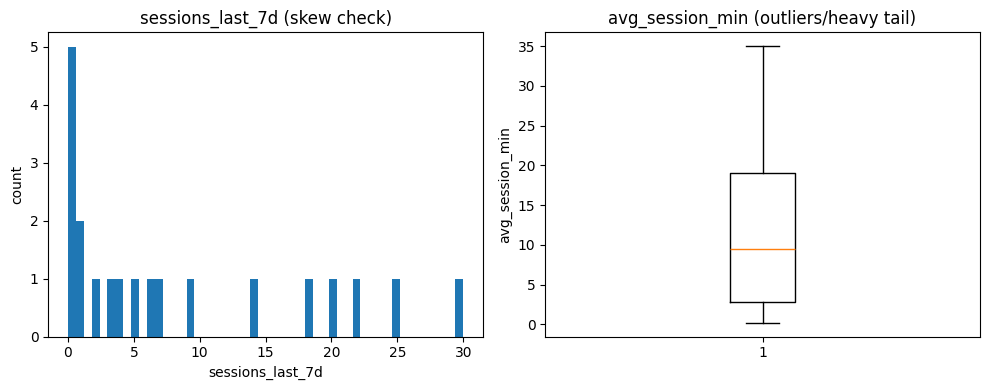

In [14]:
# TODO: pick 2 columns and create 2 plots that reveal something non-trivial
# Example: sessions_last_7d (skew), avg_session_min (heavy tail), tenure_days (range)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(df['sessions_last_7d'].dropna(), bins=50)
plt.title('sessions_last_7d (skew check)')
plt.xlabel('sessions_last_7d')
plt.ylabel('count')

plt.subplot(1,2,2)
plt.boxplot(df['avg_session_min'].dropna(), vert=True)
plt.title('avg_session_min (outliers/heavy tail)')
plt.ylabel('avg_session_min')

plt.tight_layout()
plt.show()


## 3) Target + Slices — 15 minutes


### Task 3.1: Label imbalance


In [16]:
# TODO: compute churn rate and counts
churn_rate = df['churned'].mean()
counts = df['churned'].value_counts()
print(churn_rate)
counts

# Checkpoint: which metric would you choose (accuracy vs F1 vs PR-AUC) and why?
# Use PR-AUC or F-1, not accuracy
  # Churn is usually imbalanced (few churners).
	# Accuracy can look high by always predicting “no churn”.
	# PR-AUC focuses on identifying churners and F1 balances precision and recall.


0.3


,count
churned,
0,14
1,6


### Task 3.2: Slice analysis


In [21]:
# TODO: compute churn rate by country and by plan
by_country = df.groupby('country', observed=True)['churned'].mean().sort_values(ascending=False)
by_plan = df.groupby('plan', observed=True)['churned'].mean().sort_values(ascending=False)
by_country
by_plan

# TODO: create a tenure bucket column and compute churn by bucket
# HINT: pd.cut
df2 = df.copy()
df2['tenure_bucket'] = pd.cut(
    df2['tenure_days'],
    bins=[0, 30, 90, 180, 365, float('inf')],
    labels=['0–30', '31–90', '91–180', '181–365', '365+']
)

by_bucket = df2.groupby('tenure_bucket')['churned'].mean()
by_bucket


/tmp/ipython-input-1441072753.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_bucket = df2.groupby('tenure_bucket')['churned'].mean()


,churned
tenure_bucket,
0–30,0.833333
31–90,0.000000
91–180,0.333333
181–365,0.000000
365+,0.000000


## 4) Leakage + Time — 10 minutes


### Task 4.1: Identify leakage-prone features


In [23]:
# TODO: identify columns that likely leak label or post-outcome info.
# HINT: refund_after_churn_flag looks suspicious.
leaky_cols = df['refund_after_churn_flag']
leaky_cols

# TODO: write 2-3 sentences explaining why each is leaky (prediction-time availability).
# refund_after_churn_flag is determined after a user has already churned, so it would
# not be known at prediction time. Including it gives the model access to future
# information, which artificially boosts performance. This is classic label leakage
# and must be removed before training.



,refund_after_churn_flag
0,False
1,False
2,True
3,False
4,False
5,True
6,False
7,False
8,True
9,False


## 5) Homework — EDA Write-up


In 10–15 bullets:
- Top 5 data issues/risks
    1.	Label leakage (e.g., refund_after_churn_flag is post-churn info).
    2.	Class imbalance (churners likely a small minority).
    3.	Join explosions / duplicate user_ids if merging behavioral tables.
    4.	Skewed/heavy-tailed features (sessions_last_7d, avg_session_min).
    5.	Categorical sparsity (many countries/plans with few users).
- Top 3 features to create next
    1. Engagement trends (Δ sessions vs prior period, not just last 7d).
    2. Tenure-normalized usage (sessions per tenure day).
    3. Failure signals (count/recency of payment failures, pre-churn only).
- What you would do before training any model
    1. Remove leaky columns and confirm prediction-time availability.
    2. Define proper split (time-based or user-level, no leakage).
    3. Handle imbalance (PR-AUC metric, class weights).
    4. Transform skewed features (log/winsorize).
    5. Encode categoricals safely (target/one-hot with rare handling).
    6. Baseline model + sanity checks (simple logistic, feature importances).
